In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random
import bilby

In [2]:
# different ln(likelihood) functions

def lnlikePE(var1, var2, N, C12, Sh):
    lnlike1 = -0.5*np.log(2*np.pi*var1*var2/N)
    lnlike2 = -0.5*(Sh-C12)**2/(var1*var2/N)
    return lnlike1 + lnlike2

def lnlikeSS(var1, var2, N, C12, Sh):
    lnlike1 = -0.5*N*(2*np.log(2*np.pi) + np.log(var1*var2) + 2.)
    lnlike2 = -0.5*N*(Sh**2 - 2*Sh*C12)/(var1*var2)
    return lnlike1 + lnlike2

def lnlikeSSPE(var1, var2, N, C12, Sh):
    lnlike1 = 0.5*np.log(2*np.pi*var1*var2/N) - 0.5*N*(2*np.log(2*np.pi) 
                                                       + np.log(var1*var2) + 2. - C12**2/(var1*var2))
    lnlike2 = lnlikePE(var1, var2, N, C12, Sh)
    return lnlike1 + lnlike2

In [3]:
# test case
var1 = 1.2
var2 = 1.5
N = 1024
C12 = 1.75
Sh = 0.8

PE = lnlikePE(var1, var2, N, C12, Sh)
SS1 = lnlikeSS(var1, var2, N, C12, Sh)
SS2 = lnlikeSSPE(var1, var2, N, C12, Sh)

print(PE, SS1, SS2)

-254.45820707396712 -2592.5328884330543 -2592.5328884330543


# Sufficient statistic test, white noise

In [4]:
# set some parameter values

# number of samples
N = 128

# injected values of noise and signal variances
Sh_true  = 0.3
Sn1_true = 1   
Sn2_true = 1 

# expected snr
rho = Sh_true * np.sqrt(N) / np.sqrt(Sn1_true * Sn2_true)
print('expected snr =', rho)

# flat priors for all parameters for standard gaussian model (Sh, Sn1, Sn2)
Sh_min = 1.e-6
Sh_max = 1.
Sn1_min = 0.5
Sn1_max = 2.
Sn2_min = 0.5
Sn2_max = 2.

# discrete values for parameters for standard gaussian model
N_grid = 50
Sh  = np.linspace(Sh_min, Sh_max, N_grid)
Sn1 = np.linspace(Sn1_min, Sn1_max, N_grid)
Sn2 = np.linspace(Sn2_min, Sn2_max, N_grid)

deltaSh  = Sh[1]-Sh[0]
deltaSn1 = Sn1[1]-Sn1[0]
deltaSn2 = Sn2[1]-Sn2[0]

prior_Sh = np.ones(N_grid)/(Sh_max - Sh_min)
prior_Sn1 = np.ones(N_grid)/(Sn1_max - Sn1_min)
prior_Sn2 = np.ones(N_grid)/(Sn2_max - Sn2_min)

expected snr = 3.394112549695428


0.2102424465326729 0.8955979065650987 1.119504276220617 0.011488184261094552


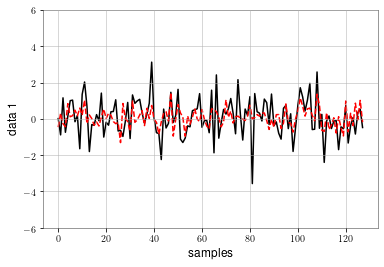

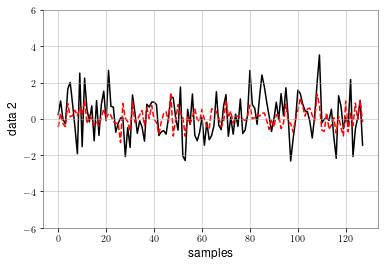

In [5]:
# simulate data
random.seed(1234)

# generate random samples
n1 = random.normal(0, np.sqrt(Sn1_true), N)
n2 = random.normal(0, np.sqrt(Sn2_true), N)
h  = random.normal(0, np.sqrt(Sh_true), N)

# add signal + noise
d1 = n1 + h
d2 = n2 + h

# estimators
C11 = np.sum(d1**2)
C22 = np.sum(d2**2)
C12 = np.sum(d1*d2)

Sh_hat  = C12/N
S1_hat = C11/N
S2_hat = C22/N
S1S2_hat = S1_hat*S2_hat
Sn1_hat = S1_hat - Sh_hat
Sn2_hat = S2_hat - Sh_hat
var_Sh_hat = S1_hat*S2_hat/N

print(Sh_hat, Sn1_hat, Sn2_hat, var_Sh_hat)

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.plot(d1, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('samples')
plt.ylabel('data 1')
plt.ylim((-6,6))
plt.savefig('./suffstat-data1.pdf', bbox_inches='tight', dpi=400)

plt.figure()
plt.rc('text', usetex=True)
plt.plot(d2, color='k')
plt.plot(h, linestyle='dashed', color='r')
plt.xlabel('samples')
plt.ylabel('data 2')
plt.ylim((-6,6))
plt.savefig('./suffstat-data2.pdf', bbox_inches='tight', dpi=400)

In [6]:
# calculate marg posterior for Sh using sufficient statistic expression for likelihood
post_Sh = np.zeros(N_grid)

for ii in range(0,N_grid):
    #print ii
    
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[jj]*Sn2[kk] + (Sn1[jj] + Sn2[kk])*Sh[ii]
            g = Sh_hat*(Sn1[jj]+Sn2[kk]) + Sn1_hat*(Sn2[kk]+Sh[ii]) + Sn2_hat*(Sn1[jj]+Sh[ii])
            
            #iN = np.diag(np.ones(N))
            
            #Cn = np.bmat([[Sn1[jj]*iN, 0.*iN],[0.*iN, Sn2[kk]*iN]])
            #C  = Cn + Sh[ii]*np.bmat([[iN, iN], [iN, iN]])
                      
            #fac1 = -0.5 * np.log(np.linalg.det(2.0*np.pi*C))
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
            
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)            
            post = like*prior_Sn1[jj]*prior_Sn2[kk]
            
            post_Sh[ii] = post_Sh[ii] + post

# normalize
post_Sh = post_Sh/np.sum(post_Sh*deltaSh)

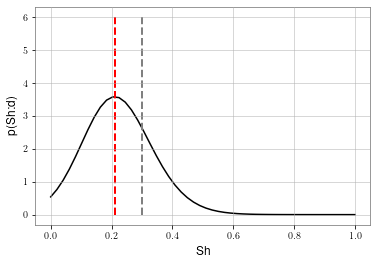

In [7]:
# plot posterior for Sh

plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sh, post_Sh, color='k')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sh')
plt.ylabel('p(Sh:d)')
plt.savefig('./suffstat-postSh.pdf', bbox_inches='tight', dpi=400)

In [8]:
# calculate marg posterior for Sn1 using sufficient statistic expression for likelihood
post_Sn1 = np.zeros(N_grid)

for ii in range(0,N_grid):
        
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[ii]*Sn2[jj] + (Sn1[ii] + Sn2[jj])*Sh[kk]
            g = Sh_hat*(Sn1[ii]+Sn2[jj]) + Sn1_hat*(Sn2[jj]+Sh[kk]) + Sn2_hat*(Sn1[ii]+Sh[kk])
            
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
                        
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)
            post = like*prior_Sh[kk]*prior_Sn2[jj]
            
            post_Sn1[ii] = post_Sn1[ii] + post
            
# normalize
post_Sn1 = post_Sn1/np.sum(post_Sn1*deltaSn1)

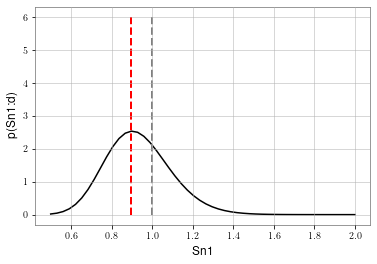

In [9]:
# plot posterior for Sn1

plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sn1, post_Sn1, color='k')
plt.plot((Sn1_true, Sn1_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn1_hat, Sn1_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sn1')
plt.ylabel('p(Sn1:d)')
plt.savefig('./suffstat-postSn1.pdf', bbox_inches='tight', dpi=400)

In [10]:
# calculate marg posterior for Sn2 using sufficient statistic expression for likelihood
post_Sn2 = np.zeros(N_grid)

for ii in range(0,N_grid):
        
    for jj in range(0,N_grid):

        for kk in range(0,N_grid):
            
            beta = Sn1[jj]*Sn2[ii] + (Sn1[jj] + Sn2[ii])*Sh[kk]
            g = Sh_hat*(Sn1[jj]+Sn2[ii]) + Sn1_hat*(Sn2[ii]+Sh[kk]) + Sn2_hat*(Sn1[jj]+Sh[kk])
            
            lnlike1 = -0.5 * N * (2.0*np.log(2.0*np.pi) + np.log(beta))
            lnlike2 = -0.5 * (N/beta) * g
                        
            lnlike = lnlike1 + lnlike2
            like = np.exp(lnlike)
            post = like*prior_Sh[kk]*prior_Sn2[ii]
            
            post_Sn2[ii] = post_Sn2[ii] + post
            
# normalize
post_Sn2 = post_Sn2/np.sum(post_Sn2*deltaSn2)

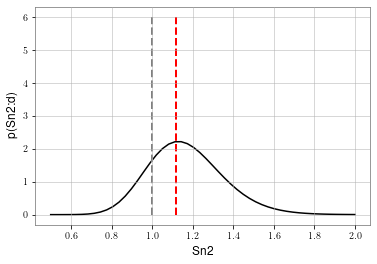

In [11]:
# plot posterior for Sn2

plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sn2, post_Sn2, color='k')
plt.plot((Sn2_true, Sn2_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn2_hat, Sn2_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sn2')
plt.ylabel('p(Sn2:d)')
plt.savefig('./suffstat-postSn2.pdf', bbox_inches='tight', dpi=400)

In [12]:
# calculate marginalized posterior for Sh (flat prior) using the sampling distribution (our PE likelihood)

post_Sh_PE = np.zeros(N_grid)

for ii in range(0,N_grid):
    
    lnlike1 = -0.5 * (np.log(2.0*np.pi) + np.log(var_Sh_hat))
    lnlike2 = -0.5 * (Sh[ii] - Sh_hat)**2 / var_Sh_hat
    lnlike = lnlike1 + lnlike2
    
    post_Sh_PE[ii] = np.exp(lnlike)
    
# normalize
post_Sh_PE = post_Sh_PE/np.sum(post_Sh_PE*deltaSh)

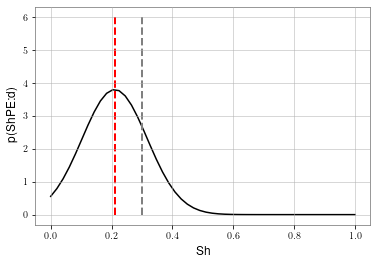

In [13]:
# plot posterior for Sh_PE

plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sh, post_Sh_PE, color='k')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sh')
plt.ylabel('p(ShPE:d)')
plt.savefig('./suffstat-postSh_PE.pdf', bbox_inches='tight', dpi=400)

In [14]:
class GaussianLikelihoodWhite(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Sh': None, 'Sn1': None, 'Sn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.Sh_hat = np.mean(d1*d2)
        self.S1_hat = np.mean(d1*d1)
        self.S2_hat = np.mean(d2*d2)
        self.Sn1_hat = self.S1_hat - self.Sh_hat
        self.Sn2_hat = self.S2_hat - self.Sh_hat
        self.S1S2_hat = self.S1_hat * self.S2_hat
        
    def log_likelihood(self):
        Sh = self.parameters['Sh']
        Sn1 = self.parameters['Sn1']
        Sn2 = self.parameters['Sn2']
                        
        # extract length of data
        N = self.N
        d1 = self.d1
        d2 = self.d2
        
        # construct NxN identity matrix
        iN = np.diag(np.ones(N))
        
        # make d1, d2 into a column vector
        d = np.bmat([d1, d2])
        d = np.transpose(d) 
        
        # construct noise and data covariance matrices
        Cn = np.bmat([[Sn1*iN, 0.*iN],[0.*iN, Sn2*iN]])
        C  = Cn + Sh*np.bmat([[iN, iN], [iN, iN]])
        
        # invert the covariance matrices using whiteness of data
        beta = Sn1*Sn2 + (Sn1 + Sn2)*Sh  
        invC  = (1.0/beta) * np.bmat([[(Sn2+Sh)*iN, -Sh*iN],[-Sh*iN, (Sn1+Sh)*iN]])
        
        # calculate ln of likelihood function 
        lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        lnlike2 = -0.5 * np.dot(np.transpose(d), np.dot(invC, d))[0]
        lnlike = lnlike1+lnlike2
        lnlike = float(lnlike)
        
        return lnlike

In [15]:
class GaussianLikelihoodSufficientStatisic(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Sh': None, 'Sn1': None, 'Sn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.Sh_hat = np.mean(d1*d2)
        self.S1_hat = np.mean(d1*d1)
        self.S2_hat = np.mean(d2*d2)
        self.Sn1_hat = self.S1_hat - self.Sh_hat
        self.Sn2_hat = self.S2_hat - self.Sh_hat
        self.S1S2_hat = self.S1_hat * self.S2_hat
        
    def log_likelihood(self):
        Sh = self.parameters['Sh']
        Sn1 = self.parameters['Sn1']
        Sn2 = self.parameters['Sn2']
        
        ###########################################
        # the following calculation uses the sufficient statistic form of the likelihood
        # (using this form for bayesian inference is then just a trivial test of MCMC)
        
        N = np.size(self.d1)
        beta = Sn1*Sn2 + (Sn1 + Sn2)*Sh        
        g = self.Sh_hat*(Sn1+Sn2) + self.Sn1_hat*(Sn2+Sh) + self.Sn2_hat*(Sn1+Sh)
        
        lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        lnlike2 = -0.5 * (N/beta) * g
        lnlike = lnlike1 + lnlike2      
        lnlike = float(lnlike)
        
        return lnlike


In [16]:
class GaussianLikelihoodColored(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Sh': None, 'Sn1': None, 'Sn2': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.Sh_hat = np.mean(d1*d2)
        self.S1_hat = np.mean(d1*d1)
        self.S2_hat = np.mean(d2*d2)
        self.Sn1_hat = self.S1_hat - self.Sh_hat
        self.Sn2_hat = self.S2_hat - self.Sh_hat
        self.S1S2_hat = self.S1_hat * self.S2_hat
        
    def log_likelihood(self):
        Sh = self.parameters['Sh']
        Sn1 = self.parameters['Sn1']
        Sn2 = self.parameters['Sn2']
        
        # extract length of data
        N = np.size(self.d1)
        
        # construct NxN identity matrix
        iN = np.diag(np.ones(N))
        
        # make d1, d2 into a column vector
        d = np.bmat([self.d1, self.d2])
        d = np.transpose(d) 
        
        # construct noise and data covariance matrices
        Cn = np.bmat([[Sn1*iN, 0.*iN],[0.*iN, Sn2*iN]])
        C  = Cn + Sh*np.bmat([[iN, iN], [iN, iN]])
        
        # invert the covariance matrices
        invC  = np.linalg.inv(C)
        
        # calculate normalization factors
        norm = 1.0/np.sqrt(np.linalg.det(2.0*np.pi*C))
                
        # calculate likelihood function and ln likelihood
        like = norm * np.exp(-0.5 * np.dot(np.transpose(d), np.dot(invC, d)))
        lnlike = np.log(like)
        lnlike = float(lnlike)
        
        return lnlike


11:09 bilby INFO    : Running for label 'lnlikeTestWhite', output will be saved to 'outdir'
11:09 bilby INFO    : Search parameters:
11:09 bilby INFO    :   Sh = Uniform(minimum=1e-06, maximum=1.0, name='Sh', latex_label='Sh', unit=None, boundary=None)
11:09 bilby INFO    :   Sn1 = Uniform(minimum=0.5, maximum=2.0, name='Sn1', latex_label='Sn1', unit=None, boundary=None)
11:09 bilby INFO    :   Sn2 = Uniform(minimum=0.5, maximum=2.0, name='Sn2', latex_label='Sn2', unit=None, boundary=None)
11:09 bilby INFO    : Single likelihood evaluation took 6.825e-04 s


injected values:

Sh = 0.3
Sn1 = 1
Sn2 = 1
0it [00:00, ?it/s]

11:09 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c24afd400>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:09 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:09 bilby INFO    : Using dynesty version 1.0.1
11:09 bilby INFO    : Using the bilby-implemented rwalk sample

6432it [02:32, 42.26it/s, bound:228 nc:1 ncall:178708 eff:4.2% logz=-390.07+/-0.08 dlogz:0.000>0.10] 



11:11 bilby INFO    : Sampling time: 0:00:00
11:11 bilby INFO    : Summary of results:
nsamples: 7432
ln_noise_evidence:    nan
ln_evidence: -390.065 +/-  0.075
ln_bayes_factor:    nan +/-  0.075



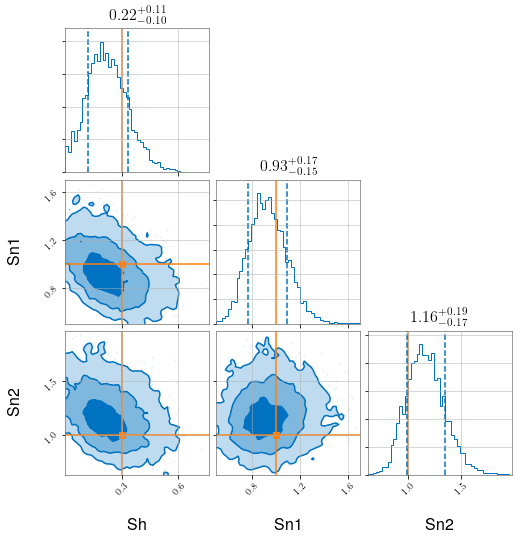

In [17]:
# run likelihood analysis

# A few simple setup steps
label = 'lnlikeTestWhite'
#label = 'lnlikeTestSufficientStatistic'
#label = 'lnlikeTestColored'

outdir = 'outdir'
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

likelihood = GaussianLikelihoodWhite(d1, d2)
priors = dict(Sh=bilby.core.prior.Uniform(Sh_min, Sh_max, 'Sh'),
              Sn1=bilby.core.prior.Uniform(Sn1_min, Sn1_max, 'Sn1'),
              Sn2=bilby.core.prior.Uniform(Sn2_min, Sn2_max, 'Sn2'))

# Now we define the injection parameters from which we've constructed simulated data
injection_parameters = dict(Sh=Sh_true, Sn1=Sn1_true, Sn2=Sn2_true)
print('injected values:\n')
print('Sh =', Sh_true)
print('Sn1 =', Sn1_true)
print('Sn2 =', Sn2_true)

# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters = injection_parameters, walks=10, outdir=outdir, label=label)
result.plot_corner()

# compare posteriors for the different methods

/anaconda3/envs/pta/lib/python3.7/site-packages/gwpy/plot/axes.py:319: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  return super().hist(x, *args, **kwargs)


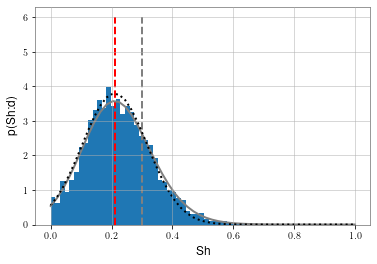

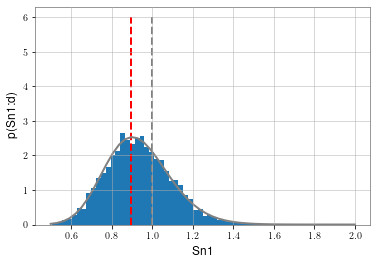

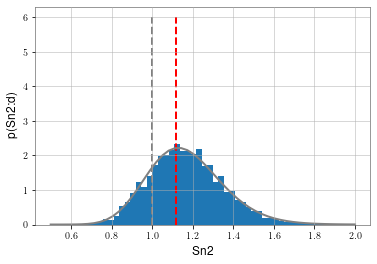

In [18]:
# Sh
chain_Sh = result.posterior["Sh"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sh, bins=50, normed='true')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sh, post_Sh, color='grey', linewidth=2, linestyle='solid')
plt.plot(Sh, post_Sh_PE, color='k', linewidth=2, linestyle='dotted')
plt.xlabel('Sh')
plt.ylabel('p(Sh:d)')
plt.savefig('./suffstat-postSh-compare.pdf', bbox_inches='tight', dpi=400)

# Sn1
chain_Sn1 = result.posterior["Sn1"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sn1, bins=50, normed='true')
plt.plot((Sn1_true, Sn1_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn1_hat, Sn1_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sn1, post_Sn1, color='grey', linewidth=2, linestyle='solid')
plt.xlabel('Sn1')
plt.ylabel('p(Sn1:d)')
plt.savefig('./suffstat-postSn1-compare.pdf', bbox_inches='tight', dpi=400)

# Sn2
chain_Sn2 = result.posterior["Sn2"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sn2, bins=50, normed='true')
plt.plot((Sn2_true, Sn2_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sn2_hat, Sn2_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sn2, post_Sn2, color='grey', linewidth=2, linestyle='solid')
plt.xlabel('Sn2')
plt.ylabel('p(Sn2:d)')
plt.savefig('./suffstat-postSn2-compare.pdf', bbox_inches='tight', dpi=400)



# Estimated auto-power

In [19]:
class GaussianLikelihoodEstimatedAutoPower(bilby.Likelihood):
    def __init__(self, d1, d2):
        """
        white noise, white signal, two coincident and coaligned detectors
        """
        super().__init__(parameters={'Sh': None})
        self.d1 = d1
        self.d2 = d2
        self.N = len(d1)
        
        # estimators
        self.Sh_hat = np.mean(d1*d2)
        self.S1_hat = np.mean(d1*d1)
        self.S2_hat = np.mean(d2*d2)
        self.Sn1_hat = self.S1_hat - self.Sh_hat
        self.Sn2_hat = self.S2_hat - self.Sh_hat
        self.S1S2_hat = self.S1_hat * self.S2_hat
        
    def log_likelihood(self):
        Sh = self.parameters['Sh']
        S1S2_hat = self.S1S2_hat
        Sh_hat = self.Sh_hat
        
        N = self.N
        beta = S1S2_hat - Sh**2        
        g = 2.*(S1S2_hat - Sh*Sh_hat)
        
        lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
        lnlike2 = -0.5 * (N/beta) * g
        lnlike = lnlike1 + lnlike2      
        lnlike = float(lnlike)
        
        return lnlike

11:11 bilby INFO    : Running for label 'lnlikeTestEstimatedAutoPower', output will be saved to 'outdir'
11:11 bilby INFO    : Search parameters:
11:11 bilby INFO    :   Sh = Uniform(minimum=1e-06, maximum=1.0, name='Sh', latex_label='Sh', unit=None, boundary=None)
11:11 bilby INFO    : Single likelihood evaluation took 6.137e-05 s


injected values:

Sh = 0.3
0it [00:00, ?it/s]

11:11 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c2714d208>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:11 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:11 bilby INFO    : Using dynesty version 1.0.1
11:11 bilby INFO    : Using the bilby-implemented rwalk sample

3778it [00:05, 748.52it/s, bound:18 nc:1 ncall:45690 eff:10.5% logz=-387.40+/-0.04 dlogz:0.000>0.10]

11:11 bilby INFO    : Sampling time: 0:00:00


11:11 bilby INFO    : Summary of results:
nsamples: 4778
ln_noise_evidence:    nan
ln_evidence: -387.397 +/-  0.037
ln_bayes_factor:    nan +/-  0.037



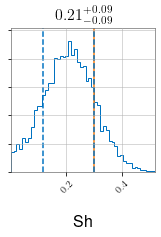

In [20]:
# run likelihood analysis

# A few simple setup steps
label = 'lnlikeTestEstimatedAutoPower'

outdir = 'outdir'
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

likelihood = GaussianLikelihoodEstimatedAutoPower(d1, d2)
priors = dict(Sh=bilby.core.prior.Uniform(Sh_min, Sh_max, 'Sh'))

# Now we define the injection parameters from which we've constructed simulated data
injection_parameters = dict(Sh=Sh_true)
print('injected values:\n')
print('Sh =', Sh_true)

# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=1000,
    injection_parameters = injection_parameters, walks=10, outdir=outdir, label=label)
result.plot_corner()

# compare posteriors for different methods

In [21]:
# calculate marginalized posterior for Sh for estimated auto-power spectra

post_Sh_autoPower = np.zeros(N_grid)

for ii in range(0,N_grid):

    beta = S1S2_hat - Sh[ii]**2        
    g = 2.*(S1S2_hat - Sh[ii]*Sh_hat)
    
    lnlike1 = -0.5 * N * (np.log(beta) + 2.0*np.log(2.0*np.pi))
    lnlike2 = -0.5 * (N/beta) * g
        
    lnlike = lnlike1 + lnlike2    
    post_Sh_autoPower[ii] = np.exp(lnlike)
    
# normalize
post_Sh_autoPower = post_Sh_autoPower/np.sum(post_Sh_autoPower*deltaSh)

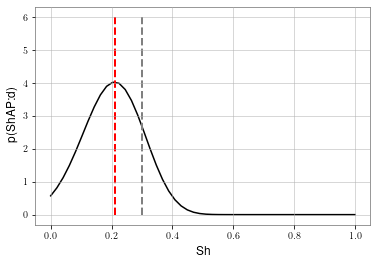

In [22]:
# plot posterior for Sh_autoPower

plt.figure()
plt.rc('text', usetex=True)
plt.plot(Sh, post_Sh_autoPower, color='k')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.xlabel('Sh')
plt.ylabel('p(ShAP:d)')
plt.savefig('./suffstat-postSh_AP.pdf', bbox_inches='tight', dpi=400)

/anaconda3/envs/pta/lib/python3.7/site-packages/gwpy/plot/axes.py:319: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  return super().hist(x, *args, **kwargs)


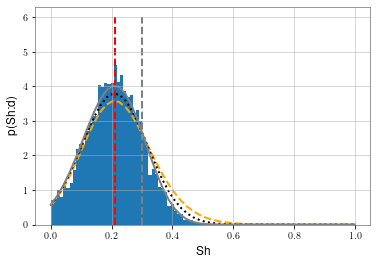

In [23]:
# Sh
chain_Sh = result.posterior["Sh"]

# plot data
plt.figure()
plt.rc('text', usetex=True)
plt.hist(chain_Sh, bins=50, normed='true')
plt.plot((Sh_true, Sh_true), (0, 6), color='grey', linewidth=2, linestyle='dashed')
plt.plot((Sh_hat, Sh_hat), (0, 6), color='red', linewidth=2, linestyle='dashed')
plt.plot(Sh, post_Sh, color='orange', linewidth=2, linestyle='dashed')
plt.plot(Sh, post_Sh_PE, color='k', linewidth=2, linestyle='dotted')
plt.plot(Sh, post_Sh_autoPower, color='grey', linewidth=2, linestyle='solid')

plt.xlabel('Sh')
plt.ylabel('p(Sh:d)')
plt.savefig('./suffstat-postSh-estimatedAutoPower-compare.pdf', bbox_inches='tight', dpi=400)